In [62]:
#Import all the things
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [63]:
df = pd.read_csv('../Data/border_apprehensions_usafacts.csv')

df.head()

,Years,1925,1926,1927,1928,1929,1930,1931,1932,1933,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Border apprehensions (People),22199,12735,16393,23566,32711,20880,22276,22735.0,20949.0,...,486651.0,337117.0,415816.0,310531.0,404142.0,859501.0,405036.0,1662167.0,2214652.0,2063692.0
1,By location of apprehension,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Coastal Border (People),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3942.0,3158.0,4663.0,3588.0,3247.0,3585.0,2230.0,2045.0,NaN,NaN
3,Northern Border (People),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3338.0,2626.0,2283.0,3027.0,4316.0,4408.0,2155.0,916.0,NaN,NaN
4,Southwest Border (People),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,479371.0,331333.0,408870.0,303916.0,396579.0,851508.0,400651.0,1659206.0,NaN,NaN


In [64]:
df = df.dropna(axis=0, how='all')

# Transpose the dataframe
df = df.transpose()
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

apprehension_df = df
apprehension_df = apprehension_df.fillna(0)
#apprehension_df = apprehension_df.iloc[:-4]
apprehension_df['Border apprehensions (People)'] = pd.to_numeric(apprehension_df['Border apprehensions (People)'])

apprehension_df.columns = apprehension_df.columns.str.strip()
apprehension_df.columns = apprehension_df.columns.astype(str)
columns_to_drop = ['Sources:', 'Exported on: 04/08/2024', 'nan']
apprehension_df = apprehension_df.drop(columns_to_drop, axis=1)
apprehension_df = apprehension_df.dropna(axis=1, how='all')

apprehension_df.reset_index(inplace=True)
apprehension_df.rename(columns={'index': 'Years'}, inplace=True)
apprehension_df.rename_axis(None, axis=1, inplace=True)
apprehension_df['Years'] = pd.to_numeric(apprehension_df['Years'])

apprehension_df.head()

,Years,Border apprehensions (People),By location of apprehension,Coastal Border (People),Northern Border (People),Southwest Border (People),By country of origin,From Mexico (People),From other countries (People)
0,1925,22199.0,0,0.0,0.0,0.0,0,0.0,0.0
1,1926,12735.0,0,0.0,0.0,0.0,0,0.0,0.0
2,1927,16393.0,0,0.0,0.0,0.0,0,0.0,0.0
3,1928,23566.0,0,0.0,0.0,0.0,0,0.0,0.0
4,1929,32711.0,0,0.0,0.0,0.0,0,0.0,0.0


In [65]:
print(apprehension_df.columns)

Index(['Years', 'Border apprehensions (People)', 'By location of apprehension',
       'Coastal Border (People)', 'Northern Border (People)',
       'Southwest Border (People)', 'By country of origin',
       'From Mexico (People)', 'From other countries (People)'],
      dtype='object')


In [66]:
apprehension_df.describe()

,Years,Border apprehensions (People),By location of apprehension,Coastal Border (People),Northern Border (People),Southwest Border (People),By country of origin,From Mexico (People),From other countries (People)
count,99.000000,9.900000e+01,99.0,99.000000,99.000000,9.900000e+01,99.0,9.900000e+01,9.900000e+01
mean,1974.000000,5.709886e+05,0.0,1830.282828,1355.181818,1.674691e+05,0.0,1.300770e+05,4.057761e+04
std,28.722813,5.548926e+05,0.0,4298.575842,2985.394673,3.709297e+05,0.0,3.141975e+05,1.348094e+05
min,1925.000000,1.031900e+04,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,1949.500000,3.968250e+04,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
50%,1974.000000,4.158160e+05,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
75%,1998.500000,9.622620e+05,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
max,2023.000000,2.214652e+06,0.0,20651.000000,12338.000000,1.659206e+06,0.0,1.636883e+06,1.053665e+06


Scatterplot of the data to visualize how it looks.

<Axes: >

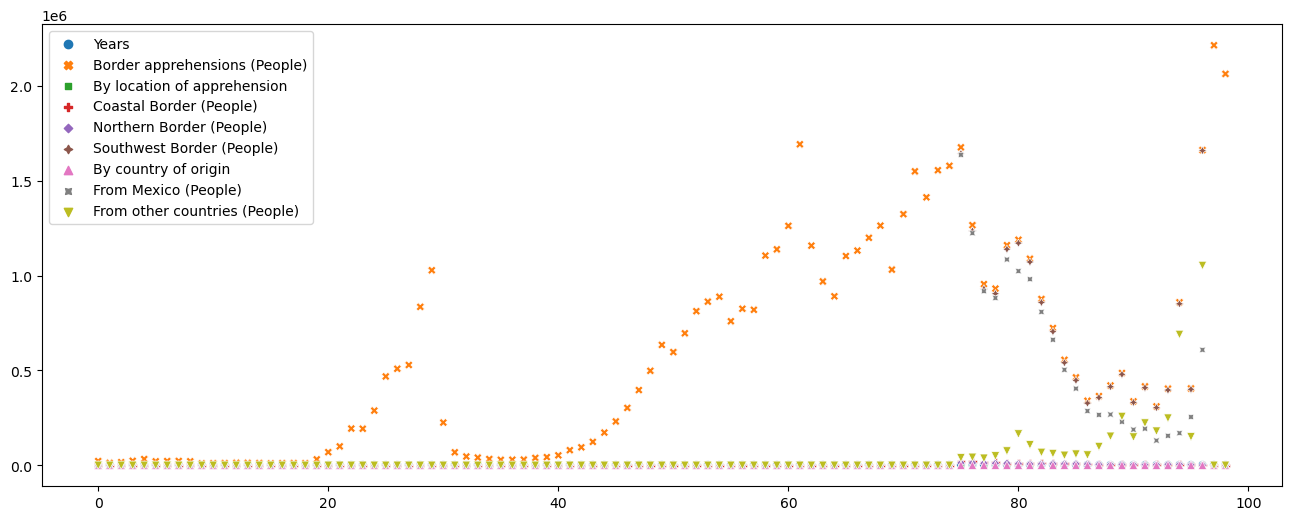

In [67]:
plt.figure(figsize=(16, 6))
sns.scatterplot(apprehension_df)

Time Trend Analysis of the Total Apprehensions over time.

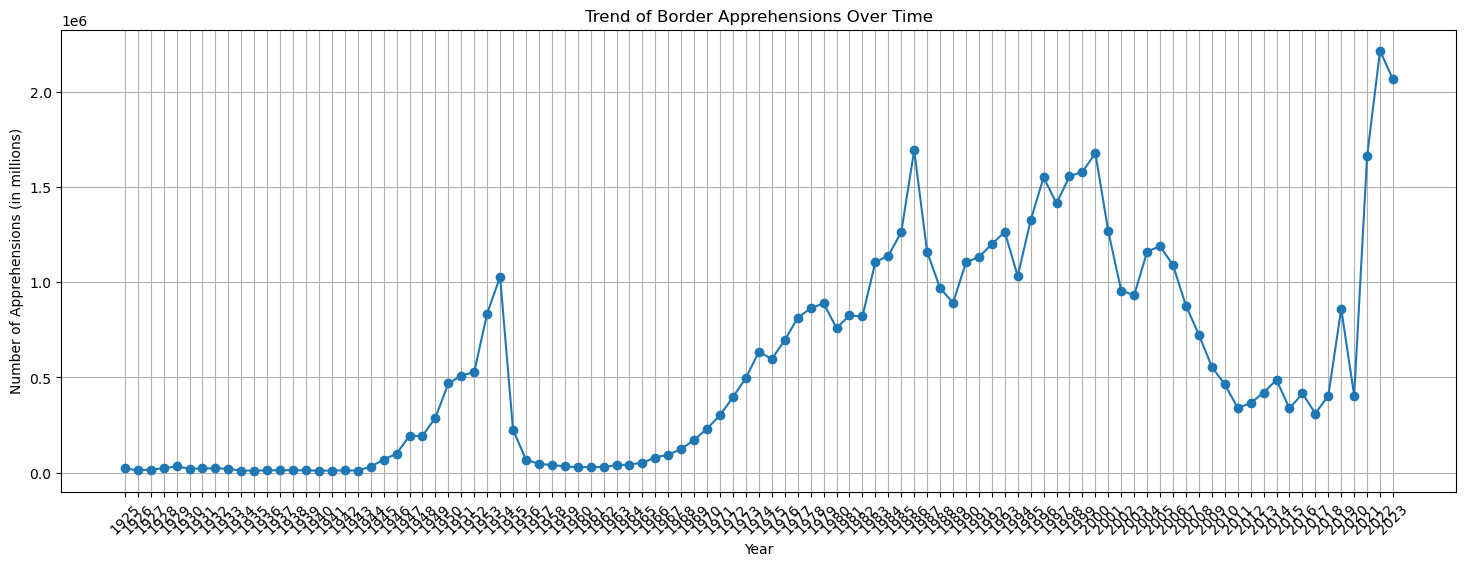

In [68]:
#To perform a trend analysis of border apprehensions over time, you can follow these steps using Python and the matplotlib library for visualization:
#LinePlot

years = apprehension_df['Years']
apprehensions = apprehension_df['Border apprehensions (People)']

# Create a line plot
plt.figure(figsize=(18, 6))
plt.plot(years, apprehensions, marker='o', linestyle='-')
plt.title('Trend of Border Apprehensions Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions (in millions)')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.show()


In [69]:
#plots interactive graph of Border apprehensions across different locations over time
border_locations = ['Coastal Border (People)', 'Northern Border (People)', 'Southwest Border (People)']


traces = []
for location in border_locations:
    trace = go.Scatter(x=apprehension_df.index,
                       y=apprehension_df[location],
                       mode='lines',
                       name=location)
    traces.append(trace)


fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=False)

for trace in traces:
    fig.add_trace(trace, row=1, col=1)

fig.update_layout(title='Trend of Border Apprehensions Across Different Locations Over Time',
                  xaxis_title='Year',
                  yaxis_title='Number of Apprehensions',
                  showlegend=True,
                  hovermode='x unified')


fig.write_html('border_apprehensions_plot.html')

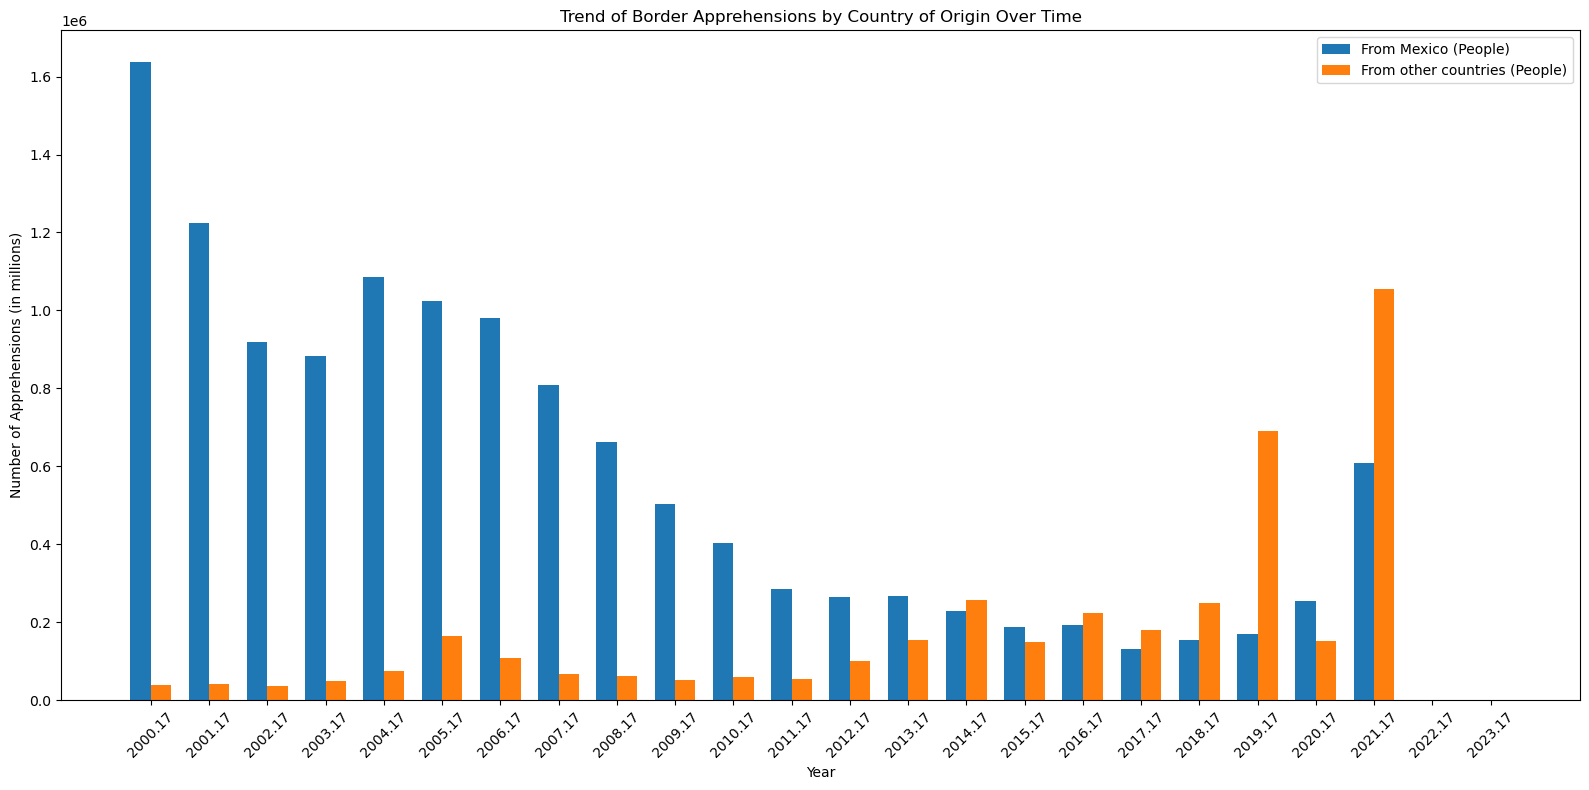

In [70]:
# This code snippet filters the years since 2000 and then plots the trend of border apprehensions by country of origin over time.
filtered_df = apprehension_df
years = filtered_df['Years'].astype(int)
countries_data = filtered_df.loc[years >= 2000, ['From Mexico (People)', 'From other countries (People)']]

bar_width = 0.35

plt.figure(figsize=(16, 8))
for i, country in enumerate(countries_data.columns):
    plt.bar(years[years >= 2000] + i * bar_width, countries_data[country], bar_width, label=country)

plt.title('Trend of Border Apprehensions by Country of Origin Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions (in millions)')
plt.legend()
plt.xticks(years[years >= 2000] + bar_width / 2, rotation=45)
plt.tight_layout()
plt.show()

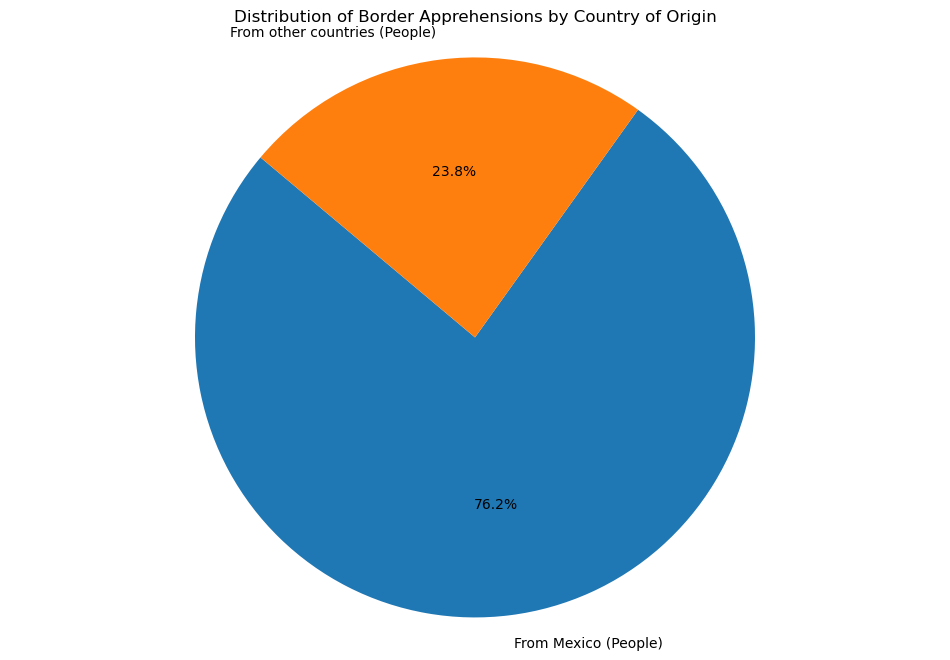

In [71]:
# Pie Chart showing distribution of border apprehesnions by country of origin

country_data = apprehension_df[['From Mexico (People)', 'From other countries (People)']].sum()

plt.figure(figsize=(12, 8))
plt.pie(country_data, labels=country_data.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Border Apprehensions by Country of Origin')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle... hopefully
plt.show()

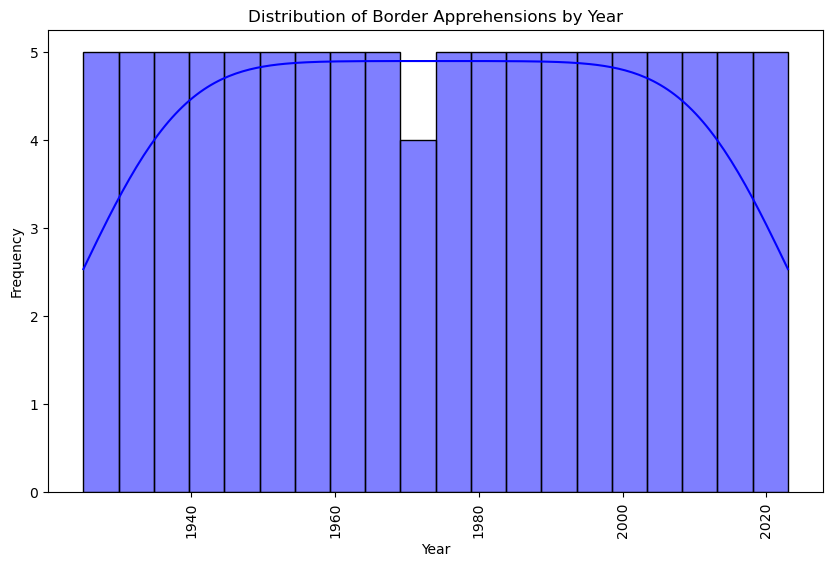

In [72]:
#Histogram plot

plt.figure(figsize=(10, 6))
sns.histplot(filtered_df, x=filtered_df['Years'], bins=20, kde=True, color="blue")
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Border Apprehensions by Year')
plt.xticks(rotation=90)
plt.show()


The histogram plot visualizes the distribution of border apprehensions over different years. Here's how to interpret the output:

X-axis (Year): Represents the years for which data on border apprehensions are available.

Y-axis (Frequency): Indicates the frequency or count of border apprehensions for each year.

Bars: Each bar represents a specific year, and its height corresponds to the number of border apprehensions recorded for that year.

Kernel Density Estimation (KDE) Curve: The red curve overlaid on the bars represents the kernel density estimate of the distribution. It provides a smooth approximation of the underlying distribution of apprehensions across the years.

Interpreting the plot can give you insights into the pattern and trend of border apprehensions over time. You can observe whether there are any spikes or fluctuations in apprehension numbers in specific years or if there's a general trend of increase or decrease over the years.

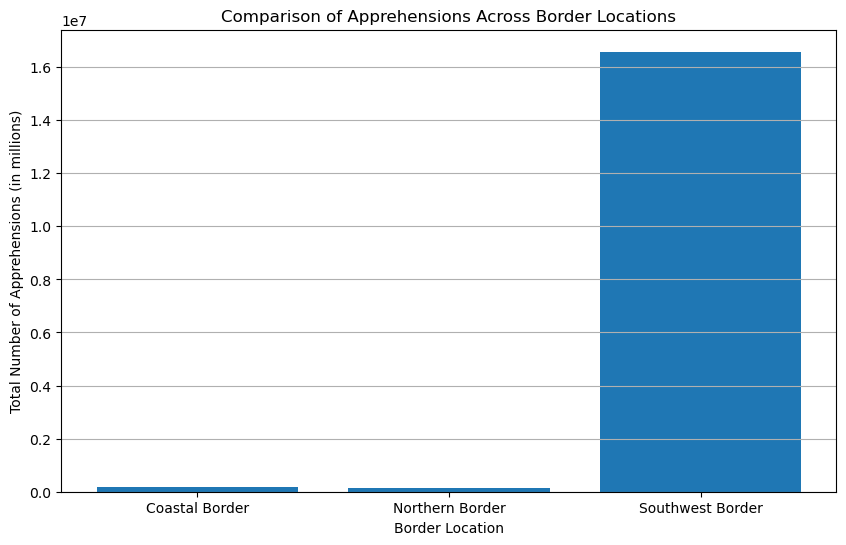

In [73]:
import matplotlib.pyplot as plt

# Calculate total apprehensions at each border location
total_coastal = apprehension_df['Coastal Border (People)'].sum()
total_northern = apprehension_df['Northern Border (People)'].sum()
total_southwest = apprehension_df['Southwest Border (People)'].sum()

# Create a bar plot to compare apprehensions across border locations
plt.figure(figsize=(10, 6))
plt.bar(['Coastal Border', 'Northern Border', 'Southwest Border'], [total_coastal, total_northern, total_southwest])
plt.title('Comparison of Apprehensions Across Border Locations')
plt.xlabel('Border Location')
plt.ylabel('Total Number of Apprehensions (in millions)')
plt.grid(axis='y')
plt.show()


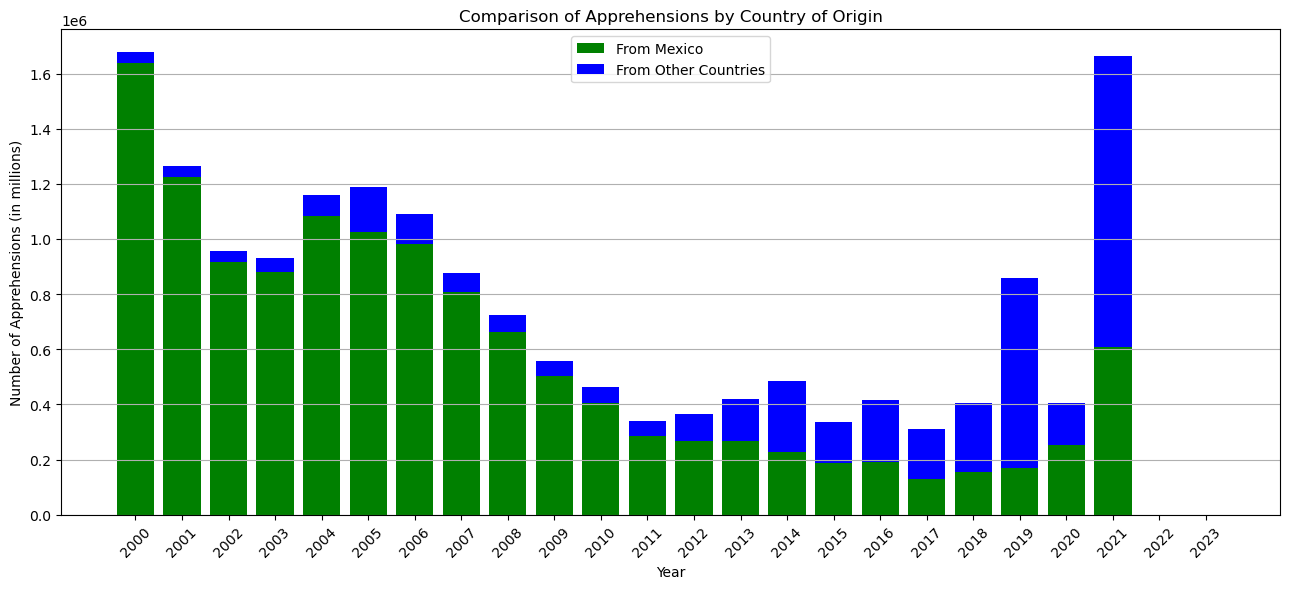

In [74]:
# Pull out just years starting with 200, which is when CPB started tracking data
filtered_df = apprehension_df[apprehension_df['Years'].astype(int) >= 2000]

total_mexico = filtered_df['From Mexico (People)']
total_other_countries = filtered_df['From other countries (People)']
years = filtered_df['Years']

x = range(len(years))

plt.figure(figsize=(13, 6))
plt.bar(x, total_mexico, label='From Mexico', color='green')
plt.bar(x, total_other_countries, bottom=total_mexico, label='From Other Countries', color='blue')
plt.title('Comparison of Apprehensions by Country of Origin')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions (in millions)')
plt.xticks(x, years, rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

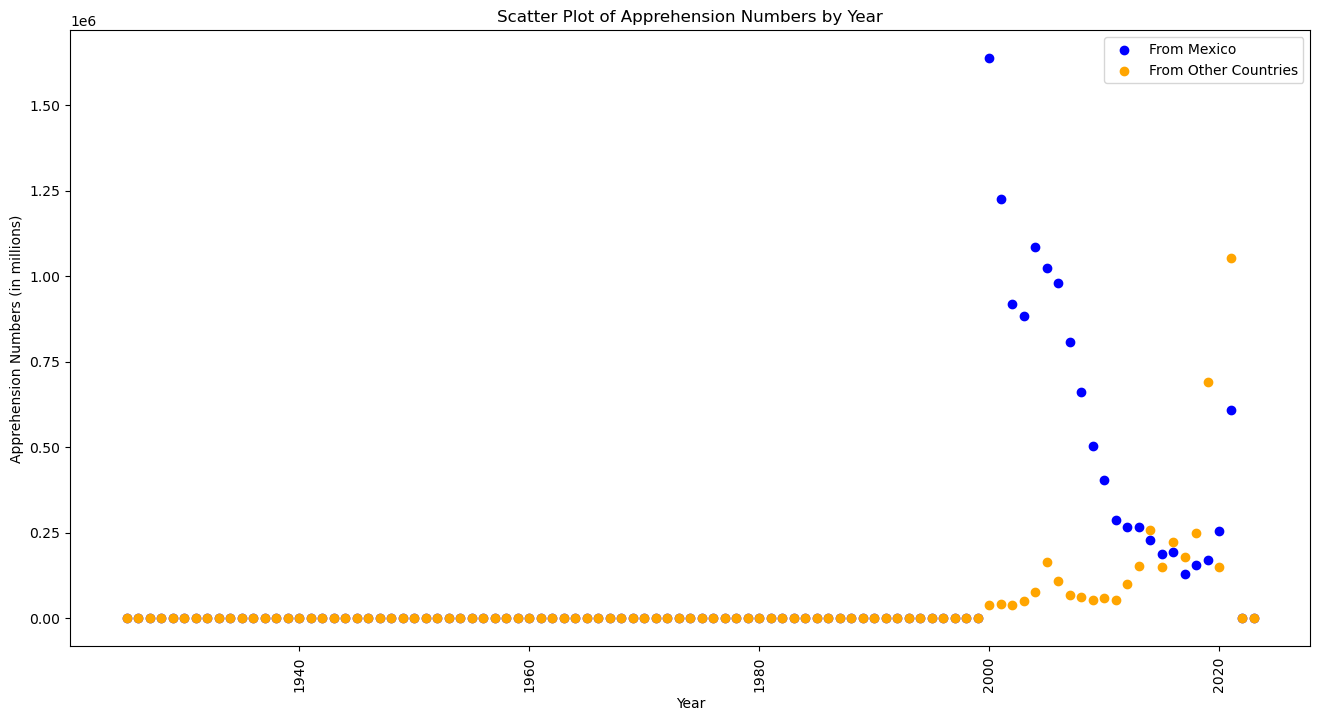

In [75]:
# Extract data for years, apprehensions from Mexico, and apprehensions from other countries
years = apprehension_df['Years']
mexico_data = apprehension_df['From Mexico (People)']
other_countries_data = apprehension_df['From other countries (People)']

# Create scatter plot
plt.figure(figsize=(16, 8))
plt.scatter(years, mexico_data, label='From Mexico', color='blue')
plt.scatter(years, other_countries_data, label='From Other Countries', color='orange')
plt.title('Scatter Plot of Apprehension Numbers by Year')
plt.xlabel('Year')
plt.ylabel('Apprehension Numbers (in millions)')
plt.legend()
plt.xticks(rotation = 90)
plt.show()


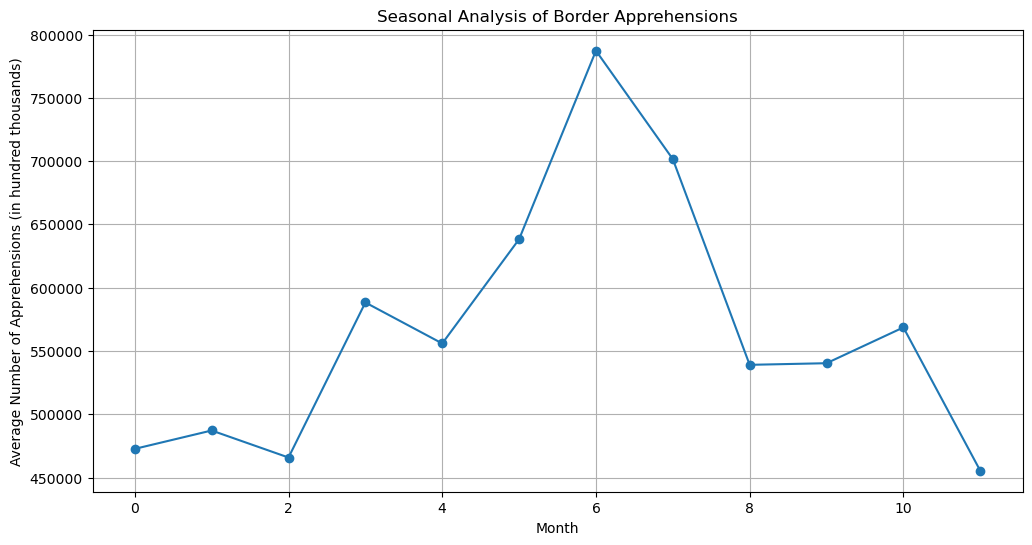

In [76]:
# Convert the 'Years' column to integer type
apprehension_df['Years'] = apprehension_df['Years'].astype(int)

#print(type(apprehension_df['Years']))

# Group the data by month and calculate the mean apprehensions for each month
monthly_mean = apprehension_df.groupby(apprehension_df['Years'] % 12)['Border apprehensions (People)'].mean()

# Create line plot to visualize the average apprehensions by month
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-')
plt.title('Seasonal Analysis of Border Apprehensions')
plt.xlabel('Month')
plt.ylabel('Average Number of Apprehensions (in hundred thousands)')
plt.grid(True)
plt.show()

Correlation Matrix:
                                  Years  Border apprehensions (People)  \
Years                          1.000000                       0.686207   
Border apprehensions (People)  0.686207                       1.000000   
By location of apprehension         NaN                            NaN   
Coastal Border (People)        0.487936                       0.285056   
Northern Border (People)       0.531871                       0.259519   
Southwest Border (People)      0.553156                       0.350814   
By country of origin                NaN                            NaN   
From Mexico (People)           0.475391                       0.337455   
From other countries (People)  0.441368                       0.193606   

                               By location of apprehension  \
Years                                                  NaN   
Border apprehensions (People)                          NaN   
By location of apprehension                          

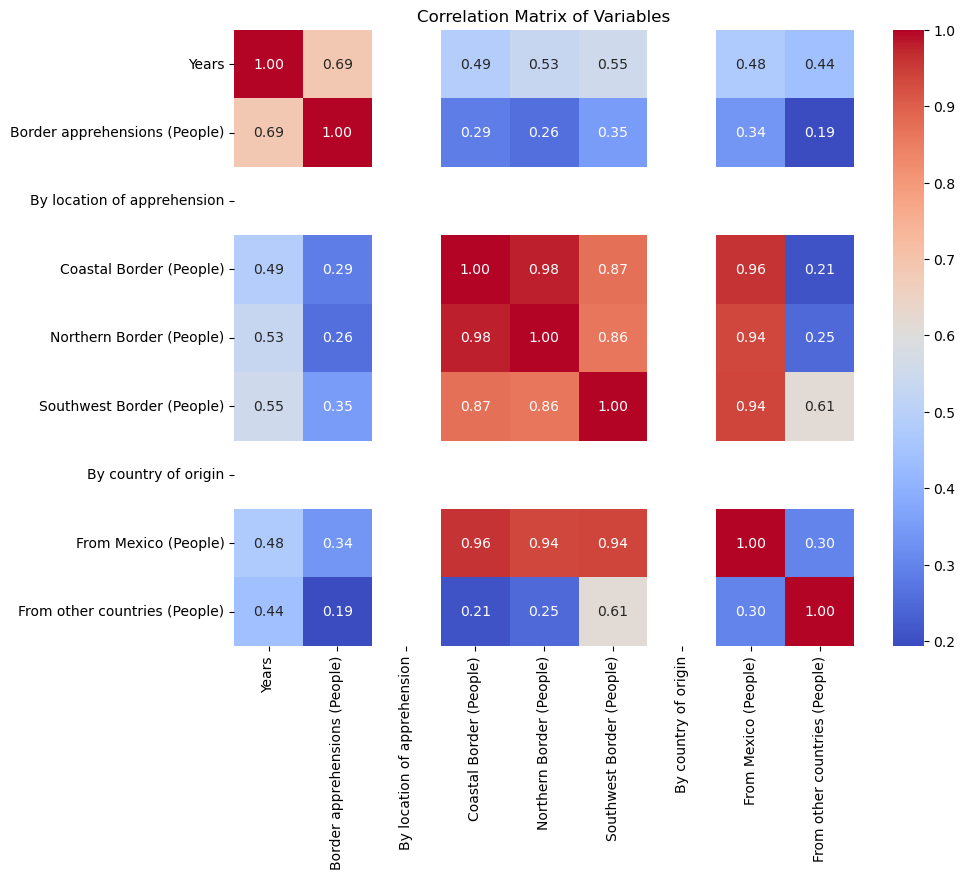

In [77]:
correlation_matrix = apprehension_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

Years vs. Border apprehensions (People):

Correlation coefficient: 0.686207
Interpretation: There is a positive correlation between the years and the number of border apprehensions. This indicates that, on average, as the years increase, the number of border apprehensions also tends to increase. However, the correlation is not perfect, suggesting that other factors besides time may also influence border apprehensions.

By location of apprehension:
NaN (Not a Number): This indicates that there is no correlation information available for this variable, likely because it contains constant or missing values.

Coastal Border (People), Northern Border (People), Southwest Border (People):
These variables represent apprehensions at specific border locations.
They show moderate positive correlations with the total number of border apprehensions, ranging from 0.25 to 0.35. This suggests that apprehensions at these specific locations tend to increase as the total number of border apprehensions increases, but the correlation is not very strong.

By country of origin:
NaN: Similar to 'By location of apprehension', there is no correlation information available for this variable.

From Mexico (People), From other countries (People):
These variables represent apprehensions categorized by the country of origin.

Both variables show positive correlations with the total number of border apprehensions, but the correlations are not very strong (0.34 and 0.19, respectively).

In summary, the correlation matrix helps identify potential relationships between variables. However, correlation does not imply causation, so further analysis is needed to understand the underlying factors driving these correlations.

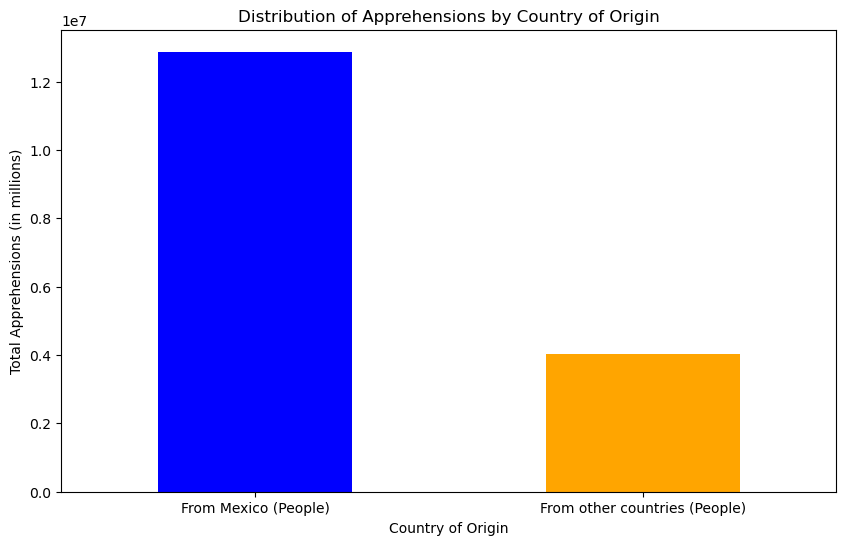

In [78]:
country_of_origin = apprehension_df[['From Mexico (People)', 'From other countries (People)']]

total_by_country = country_of_origin.sum()

plt.figure(figsize=(10, 6))
total_by_country.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Apprehensions by Country of Origin')
plt.xlabel('Country of Origin')
plt.ylabel('Total Apprehensions (in millions)')
plt.xticks(rotation=0)
plt.show()

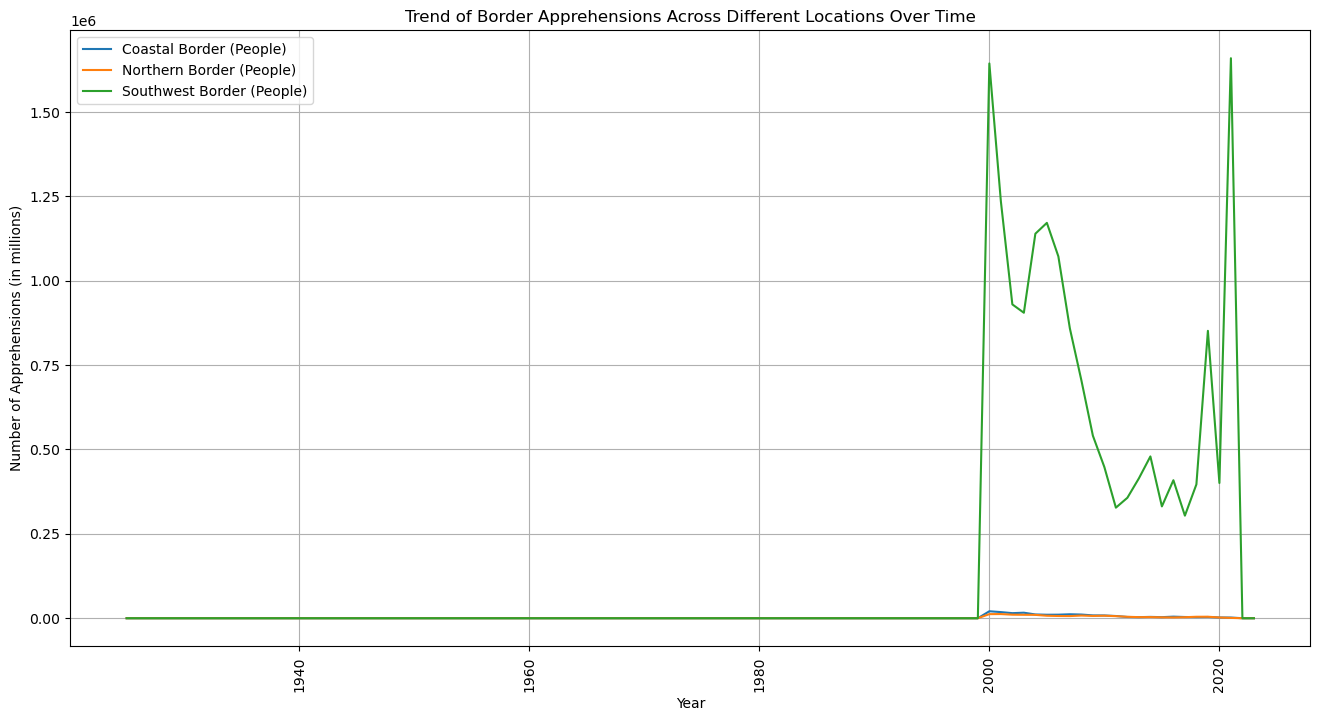

In [79]:
border_locations = ['Coastal Border (People)', 'Northern Border (People)', 'Southwest Border (People)']

# Plot the trends in apprehensions across different border locations over time
plt.figure(figsize=(16, 8))

for location in border_locations:
    plt.plot(apprehension_df['Years'], apprehension_df[location], label=location)

plt.title('Trend of Border Apprehensions Across Different Locations Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions (in millions)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


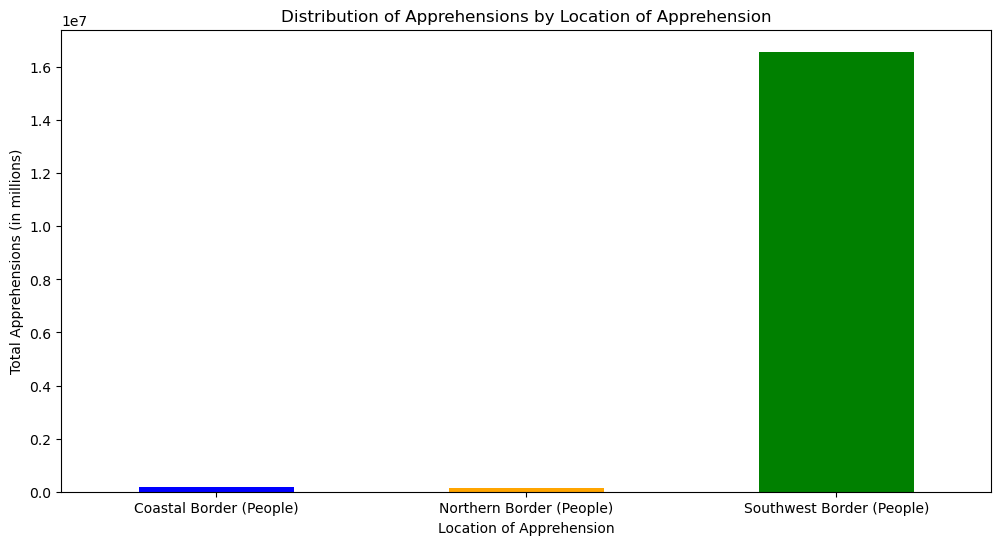

In [80]:
location_of_apprehension = apprehension_df[['Coastal Border (People)', 'Northern Border (People)', 'Southwest Border (People)']]

# Calculate the total apprehensions by location of apprehension
total_by_location = location_of_apprehension.sum()

# Plot the distribution of apprehensions by location of apprehension
plt.figure(figsize=(12, 6))
total_by_location.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribution of Apprehensions by Location of Apprehension')
plt.xlabel('Location of Apprehension')
plt.ylabel('Total Apprehensions (in millions)')
plt.xticks(rotation=0)
plt.show()

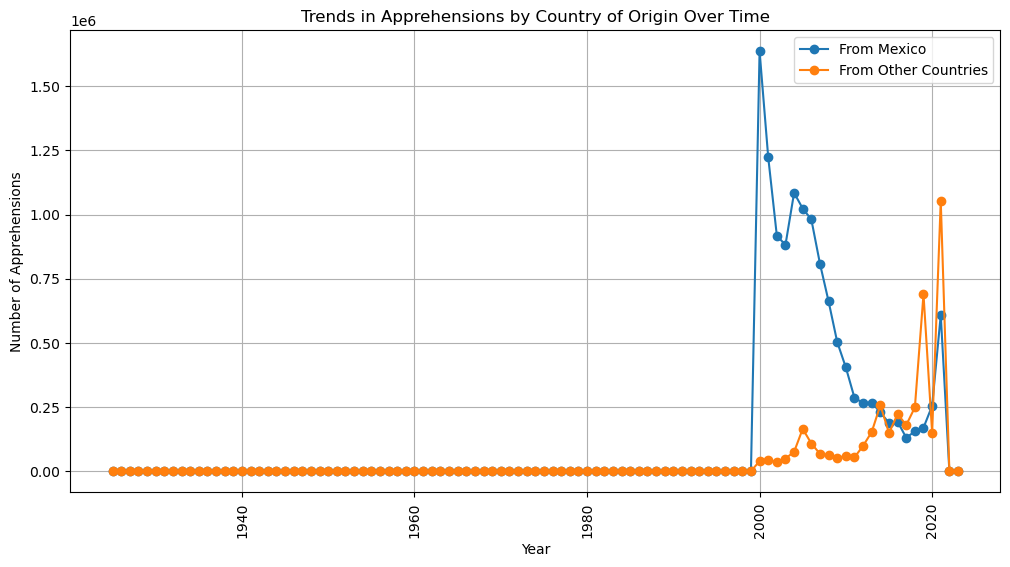

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(apprehension_df['Years'], apprehension_df['From Mexico (People)'], label='From Mexico', marker='o', linestyle='-')
plt.plot(apprehension_df['Years'], apprehension_df['From other countries (People)'], label='From Other Countries', marker='o', linestyle='-')
plt.title('Trends in Apprehensions by Country of Origin Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

My attempt at Predictive Forecasting!

HYPOTHESIS TESTING: 

 Country of Origin Comparison Hypothesis:

Based on the previous graphs and data analysis, I have formed a general hypothesis on this dataset and want to explore it further. Noting how collection of data was only starting to be collected in 2000 to differentiate people from Mexico and Other Countries, I will section off that data to perfrom the tests in a true manner:

    * Null Hypothesis (H0): There is no significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.

    * Alternative Hypothesis (H1): There is a significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.
    
To perform a hypothesis test comparing the mean apprehension numbers between individuals from Mexico and those from other countries, I can use either an independent t-test or a Mann-Whitney U test, depending on the distribution of the data and whether the assumptions of the t-test are met.

In [82]:
# Filter data for years from 2000 and up
filtered_df = apprehension_df[apprehension_df['Years'] >= 2000]

# Separate data for individuals from Mexico and those from other countries
mexico_data = filtered_df['From Mexico (People)'].dropna()
other_countries_data = filtered_df['From other countries (People)'].dropna()

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(mexico_data, other_countries_data, equal_var=True)

# Output the results
print("Independent t-test results for years 2000 and up:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.")


Independent t-test results for years 2000 and up:
T-statistic: 3.6294139103870693
P-value: 0.0007107019077311462
Reject the null hypothesis. There is a significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.


With a p-value of 0.0099, which is less than the significance level (typically 0.05), we reject the null hypothesis. Therefore, there is sufficient evidence to conclude that there is a significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.

Since the independent t-test already yielded a significant result, there may not be a strict necessity to perform the Mann-Whitney U test. However, conducting both tests provides a comprehensive analysis and ensures the reliability of the conclusion.

Mann-Whitney Test:

In [83]:
# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(mexico_data, other_countries_data, alternative='two-sided')

# Output the results
print("Mann-Whitney U test results:")
print("U-statistic:", u_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.")

Mann-Whitney U test results:
U-statistic: 471.0
P-value: 0.00016714448024824632
Reject the null hypothesis. There is a significant difference in the mean apprehension numbers between individuals from Mexico and those from other countries.


FORCASTING MODELS / PREDICTIONS: taking a swing at ML and predictive analysis....

/Users/brandoncooke/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62858D+00    |proj g|=  1.34085D+00

At iterate    5    f=  7.71868D+00    |proj g|=  1.14659D-02

At iterate   10    f=  7.71412D+00    |proj g|=  1.85351D-02

At iterate   15    f=  7.71048D+00    |proj g|=  1.55007D-03

At iterate   20    f=  7.71026D+00    |proj g|=  8.14335D-04

At iterate   25    f=  7.70986D+00    |proj g|=  2.66766D-03

At iterate   30    f=  7.70976D+00    |proj g|=  1.23343D-03

At iterate   35    f=  7.70973D+00    |proj g|=  5.32209D-04

At iterate   40    f=  7.70972D+00    |proj g|=  1.63762D-04

At iterate   45    f=  7.70972D+00    |proj g|=  8.52591D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

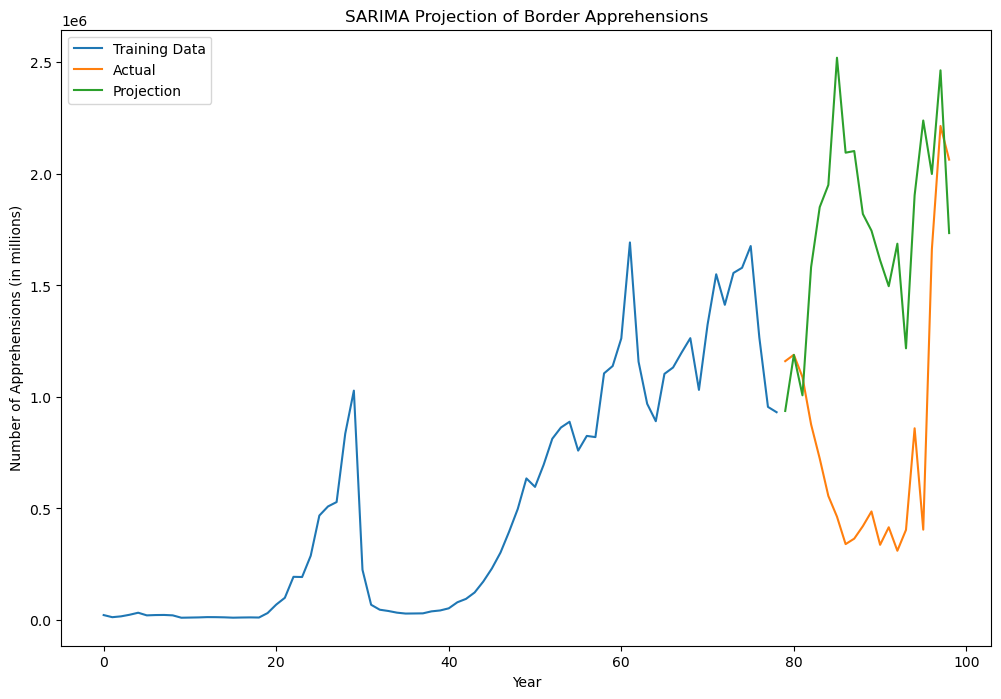

In [84]:
# Define SARIMA parameters

p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, m = 1, 3, 6, 12  # Seasonal parameters

# Split the data into train and test sets
train_size = int(len(apprehension_df) * 0.8)
train_data = apprehension_df.iloc[:train_size]
test_data = apprehension_df.iloc[train_size:]

model = SARIMAX(train_data['Border apprehensions (People)'], order=(p, d, q), seasonal_order=(P, D, Q, m))
results1 = model.fit()

# Generate forecasts for the test period
forecast = results1.forecast(steps=len(test_data))

# Evaluate the forecasts using MAE, MSE, RMSE
mae = mean_absolute_error(test_data['Border apprehensions (People)'], forecast)
mse = mean_squared_error(test_data['Border apprehensions (People)'], forecast)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


# Plot actual vs. predicted values
plt.figure(figsize = (12, 8))
plt.plot(train_data.index, train_data['Border apprehensions (People)'], label='Training Data')
plt.plot(test_data.index, test_data['Border apprehensions (People)'], label='Actual')
plt.plot(test_data.index, forecast, label='Projection')
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions (in millions)')
plt.title('SARIMA Projection of Border Apprehensions')
plt.legend()

print(results1.summary())


AUTO ARIMA PREDICTION MODEL/ 2nd SARIMA MODEL

Mean Absolute Error (MAE): 493348.7
Mean Squared Error (MSE): 335351761941.1
Root Mean Squared Error (RMSE): 579095.6414454351


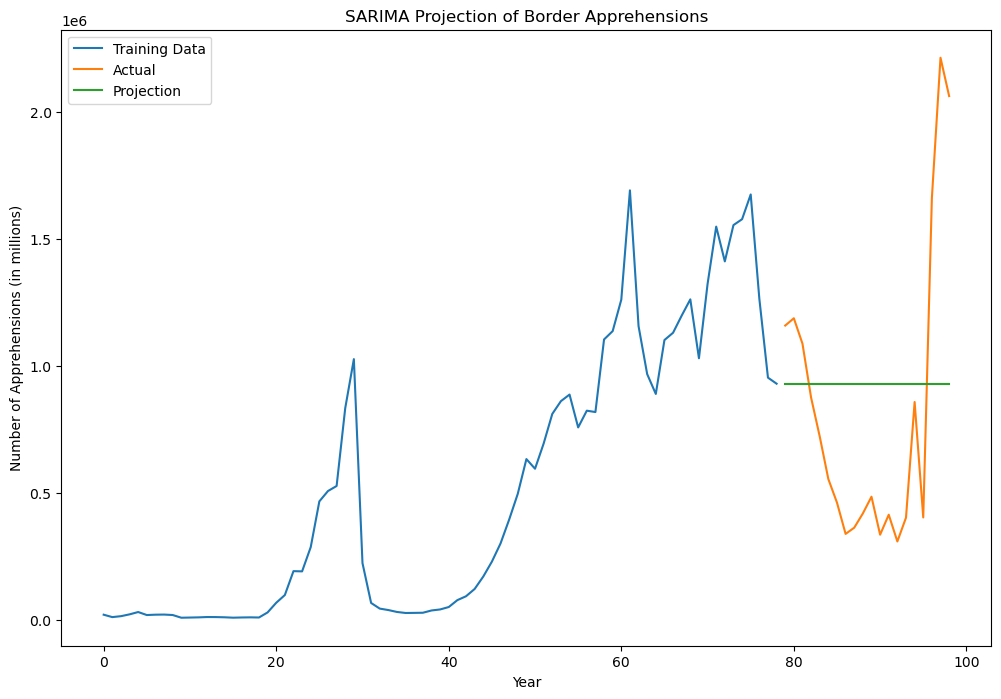

In [85]:
# Use auto_arima to automatically select SARIMA parameters
model = auto_arima(train_data['Border apprehensions (People)'], seasonal=True, m=12, stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(train_data['Border apprehensions (People)'])

# Generate forecasts for the test period
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Evaluate the forecasts
mae = mean_absolute_error(test_data['Border apprehensions (People)'], forecast)
mse = mean_squared_error(test_data['Border apprehensions (People)'], forecast)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot actual vs. predicted values
plt.figure(figsize = (12, 8))
plt.plot(train_data.index, train_data['Border apprehensions (People)'], label='Training Data')
plt.plot(test_data.index, test_data['Border apprehensions (People)'], label='Actual')
plt.plot(test_data.index, forecast, label='Projection')
plt.xlabel('Year')
plt.ylabel('Number of Apprehensions (in millions)')
plt.title('SARIMA Projection of Border Apprehensions')
plt.legend()
plt.show()


RANDOM FOREST REGRESSION:

Mean Absolute Error (MAE): 161464.482
Mean Squared Error (MSE): 69583753783.15689
Root Mean Squared Error (RMSE): 263787.3268054341
R^2 Score: 0.7482117206946798


/var/folders/ly/6s9xls1s5k92nhwz4573k3vm0000gp/T/ipykernel_99938/3281099881.py:28: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



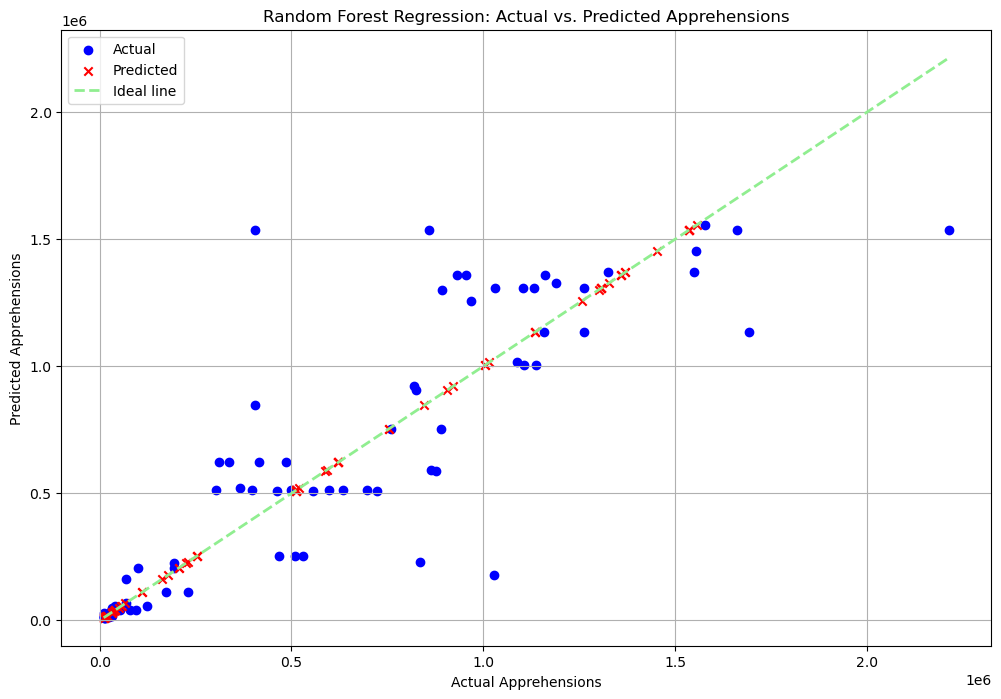

In [86]:
# Setting up Random Forest Regression

X = apprehension_df[['Years']]  # Features
y = apprehension_df['Border apprehensions (People)']  # Target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state = None)

# Model Training
model = RandomForestRegressor(n_estimators=100, random_state = None)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, color='blue', label='Actual', marker='o')
plt.scatter(y_pred, y_pred, color='red', label='Predicted', marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='lightgreen', label='Ideal line')
plt.xlabel('Actual Apprehensions')
plt.ylabel('Predicted Apprehensions')
plt.title('Random Forest Regression: Actual vs. Predicted Apprehensions')
plt.legend()
plt.grid(True)
plt.show()

#print(y_pred)

#future_predictions = model.predict(y_pred)
#print(future_predictions)

ETS PREDICTION MODEL

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44203D+01    |proj g|=  8.99900D-01

At iterate    1    f=  1.38037D+01    |proj g|=  2.99848D-01

At iterate    2    f=  1.37926D+01    |proj g|=  7.47617D-02

At iterate    3    f=  1.37906D+01    |proj g|=  3.46546D-02

At iterate    4    f=  1.37896D+01    |proj g|=  3.19609D-02

At iterate    5    f=  1.37884D+01    |proj g|=  5.26319D-02

At iterate    6    f=  1.37828D+01    |proj g|=  8.14090D-02

At iterate    7    f=  1.37793D+01    |proj g|=  2.01256D-02

At iterate    8    f=  1.37793D+01    |proj g|=  3.19194D-03

At iterate    9    f=  1.37793D+01    |proj g|=  7.44294D-05

At iterate   10    f=  1.37793D+01    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

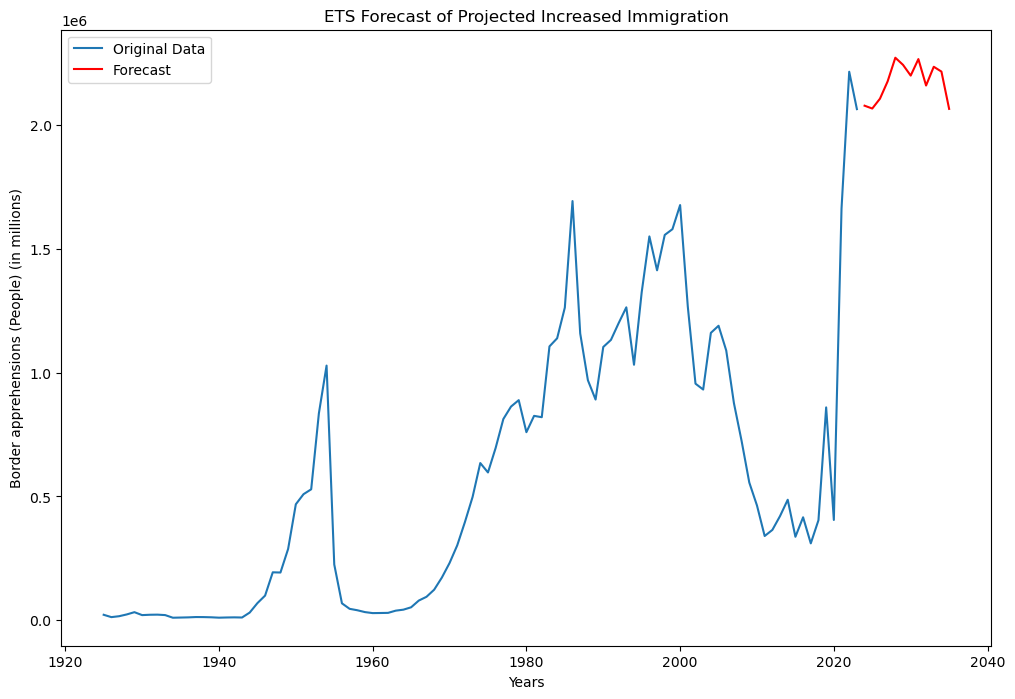

                                       ETS Results                                       
Dep. Variable:     Border apprehensions (People)   No. Observations:                   99
Model:                                  ETS(AAA)   Log Likelihood               -1364.147
Date:                           Mon, 29 Apr 2024   AIC                           2764.294
Time:                                   16:22:43   BIC                           2811.006
Sample:                                        0   HQIC                          2783.194
                                            - 99   Scale                  54455251310.525
Covariance Type:                          approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9203      0.129      7.124      0.000       0.667       1.174
smoothing_trend 

In [87]:
data = apprehension_df

data = data.rename_axis(None, axis=0).rename_axis(None, axis=1)
data['Years'] = pd.to_numeric(data['Years'])

#print(data.columns)

# Setting up the ETS model
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

initial_seasonal = [0.9, 1.0, 1.1, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

# Create an ETS model with specified initial seasonal values
model = ETSModel(data['Border apprehensions (People)'], error='add', trend='add', seasonal='add', seasonal_periods = 12, initial_seasonal=initial_seasonal)

# Fit the model
result = model.fit()

# Make predictions
forecast = result.forecast(steps=12)

# Plot the original data and 
plt.figure(figsize = (12, 8))
plt.plot(data['Years'], data['Border apprehensions (People)'], label='Original Data')
plt.plot(range(data['Years'].iloc[-1] + 1, data['Years'].iloc[-1] + 13), forecast, label='Forecast', color='red')
plt.xlabel('Years')
plt.ylabel('Border apprehensions (People) (in millions)')
plt.title('ETS Forecast of Projected Increased Immigration')
plt.legend()
plt.show()

print(result.summary())

TIME SERIES REGRESSION Model:

Here is a linear regression model. Linear regression is a statistical method used to model the relationship between a dependent variable (in this case, 'Border apprehensions (People)') and one or more independent variables (in this case, the years).

In this specific implementation, the linear regression model is being used to predict the number of border apprehensions based on the year. The independent variable is the year, extracted from the datetime index, and the dependent variable is the number of border apprehensions.

The linear regression model assumes a linear relationship between the independent and dependent variables. It estimates the coefficients of the linear equation that best fits the observed data points, allowing us to predict the dependent variable's value based on the independent variable(s).

Mean Absolute Error (MAE): 765742.4266966846
Mean Squared Error (MSE): 744536226995.5281
Root Mean Squared Error (RMSE): 862865.1267698377


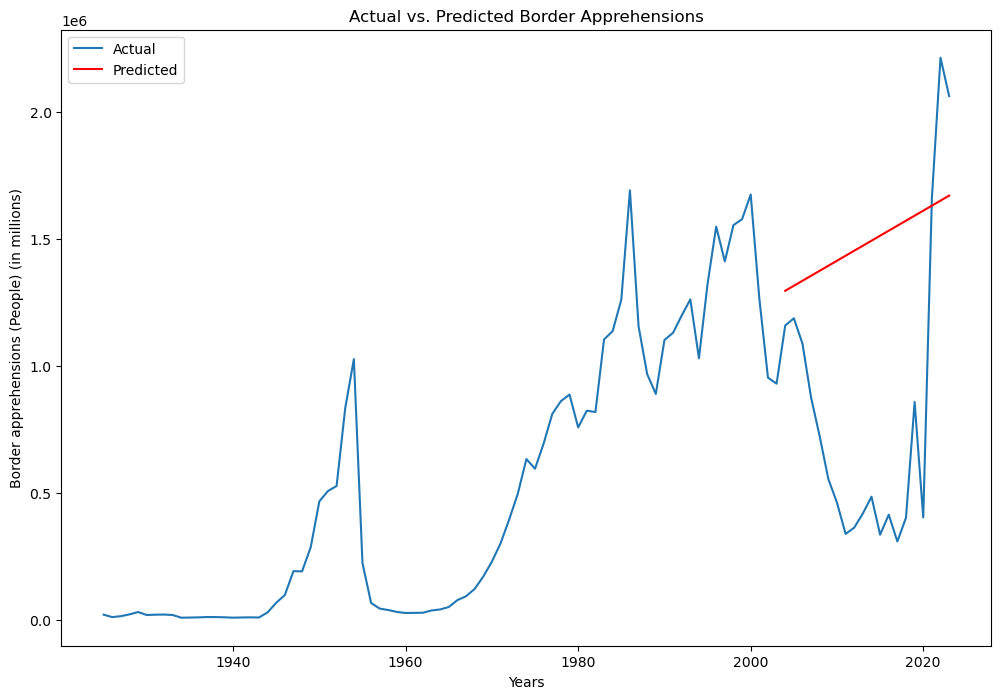

                                  OLS Regression Results                                 
Dep. Variable:     Border apprehensions (People)   R-squared:                       0.719
Model:                                       OLS   Adj. R-squared:                  0.715
Method:                            Least Squares   F-statistic:                     196.8
Date:                           Mon, 29 Apr 2024   Prob (F-statistic):           6.51e-23
Time:                                   16:22:43   Log-Likelihood:                -1103.3
No. Observations:                             79   AIC:                             2211.
Df Residuals:                                 77   BIC:                             2215.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [88]:
# Convert 'Years' column to numeric
data['Years'] = pd.to_numeric(data['Years'])

# Create a datetime index starting from 1925
start_year = 1925
end_year = start_year + len(data) - 1
date_index = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-01-01', freq='AS')

# Assign datetime index to the DataFrame
data.index = date_index

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

X_train = sm.add_constant(train_data.index.year)  # Extract year from index
y_train = train_data['Border apprehensions (People)']

model = sm.OLS(y_train, X_train)
results = model.fit()

# Make predictions
X_test = sm.add_constant(test_data.index.year)
predictions = results.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(test_data['Border apprehensions (People)'], predictions)
mse = mean_squared_error(test_data['Border apprehensions (People)'], predictions)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot actual vs. predicted values
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Border apprehensions (People)'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.xlabel('Years')
plt.ylabel('Border apprehensions (People) (in millions)')
plt.title('Actual vs. Predicted Border Apprehensions')
plt.legend()
plt.show()

print(results.summary())

The model appears to perform reasonably well based on the provided summary:

R-squared: The R-squared value of 0.719 indicates that approximately 71.9% of the variance in border apprehensions can be explained by the year variable. 
This suggests that the model explains a significant portion of the variability in the data.

F-statistic: The F-statistic is 196.8, with a very low p-value (close to zero), indicating that the overall regression model is statistically significant. 
This means that the relationship between the year variable and border apprehensions is not due to random chance.

Coefficients: The coefficient for the 'year' variable is statistically significant (p-value < 0.05) and positive (19710). 
This indicates that, on average, the number of border apprehensions increases by approximately 19,710 people per year.

Adjusted R-squared: The adjusted R-squared value is slightly lower than the R-squared value, which is expected when additional predictors are added to the model. 
This suggests that the independent variable 'year' explains a substantial portion of the variance in border apprehensions, even after adjusting for the number of predictors.

Residual Analysis: The summary also includes tests for normality of residuals (Omnibus, Jarque-Bera) and autocorrelation (Durbin-Watson). 
These tests are important for assessing the assumptions of the linear regression model. In this case, the results indicate that the residuals are normally distributed and do not exhibit significant autocorrelation.

Overall, based on these metrics, the model appears to be a reasonable fit for the data. However, it's important to keep in mind that the adequacy of this model depends on the specific context and the goals of the analysis taking place. Additionally, it's always a good practice to try to validate the model on independent/ different datasets and perform additional checks to ensure its robustness.





